Demonstration notebook for MIT talk. © Neel Joshi.

# Prerequisites

## Imports

In [ ]:
# SKIP IF ALREADY CLONED
! git clone https://github.com/neeldjoshi97/MIT_Manipal_Talk_Data_4_9_24.git mydata

Cloning into 'mydata'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 974.55 KiB | 3.35 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
!pip install nashpy -q

In [3]:
import os
import time
import json
import cv2 as cv
import numpy as np
import nashpy as nash
import networkx as nx
import ipywidgets as widgets
import networkx.algorithms.approximation as nx_app

from numpy.linalg import svd
from google.colab import output
output.enable_custom_widget_manager()
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from ipywidgets import interact, IntSlider, FloatSlider, fixed
%matplotlib inline

## Setup

In [ ]:
root = os.getcwd()
data_path = os.path.join(root, 'data')

In [5]:
root

'/content'

In [6]:
seed = 0
np.random.seed(seed=seed)

In [7]:
np.set_printoptions(suppress=True)

## Helper Functions

In [8]:
def summary(array):
  '''
  Provides quick statistics for an array
  '''
  min = np.around(np.min(array), 2)
  max = np.around(np.max(array), 2)
  avg = np.around(np.mean(array), 2)
  med = np.around(np.median(array), 2)

  print(f"min: {min}\nmax: {max}\nmean: {avg}\nmedian: {med}")

def size_in_kb(file_path):
  '''
  Provides file size in KB
  '''
  kb = os.stat(file_path).st_size/1000
  return f"{round(kb, 1)} KB"

def freq_mask(shape_tuple, x, y):
  '''
  Creates frequency filter mask for given shape
  '''
  H, W  = shape_tuple
  mask  = np.ones((H, W), dtype=np.uint8)
  mask[H//2 - y : H//2 + y, W//2 - x : W//2 + x] = 0
  return mask

def read_network_from_file(file_path):
  '''
  Reads graph from saved file format
  '''
  fh    = open(file_path, 'r')
  data  = fh.read()
  fh.close()

  return nx.node_link_graph(json.loads(data))

def save_network(net, filename):
  '''
  Saves graph to given file
  '''
  data  = json.dumps(net, default=nx.node_link_data)
  fh    = open(filename, 'w')
  fh.write(data)
  fh.close()

## Working with an Image

In [9]:
# read image 'lena.png'
img = cv.imread(os.path.join(data_path, 'lena.png'))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [10]:
img.shape

(512, 512, 3)

In [11]:
# split image into channels
img_red = np.zeros(img.shape, dtype=img.dtype)
img_red[:, :, 0] = img[:, :, 0]

img_green = np.zeros(img.shape, dtype=img.dtype)
img_green[:, :, 1] = img[:, :, 1]

img_blue = np.zeros(img.shape, dtype=img.dtype)
img_blue[:, :, 2] = img[:, :, 2]

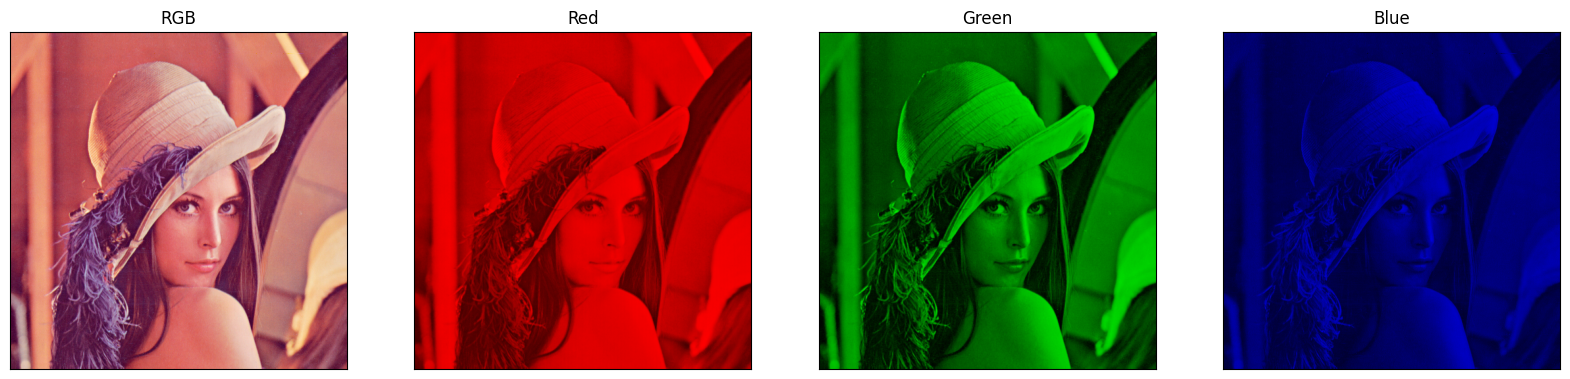

In [12]:
# plot image and individual channels
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

plt.subplot(141), plt.imshow(img)
plt.title('RGB'), plt.xticks([]); plt.yticks([]);

plt.subplot(142), plt.imshow(img_red)
plt.title('Red'), plt.xticks([]); plt.yticks([]);

plt.subplot(143), plt.imshow(img_green)
plt.title('Green'), plt.xticks([]); plt.yticks([]);

plt.subplot(144), plt.imshow(img_blue)
plt.title('Blue'), plt.xticks([]); plt.yticks([]);

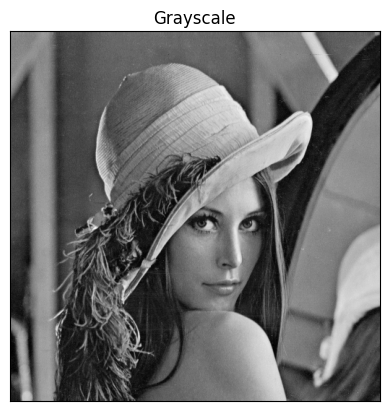

In [13]:
# plot grayscale image
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(img_gray, cmap='gray');
plt.title('Grayscale'); plt.xticks([]); plt.yticks([]);

# Harris Corner Detection

In [14]:
def find_corners(file_path, blockSize=2, ksize=3, alpha=0.04):
  '''
  Function to find corners in an image
  '''
  # read image from path
  img = cv.imread(file_path)

  # preprocess
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  gray = np.float32(gray)

  # detect corners using Harris method
  dst = cv.cornerHarris(gray, blockSize, ksize, alpha)

  # threshold for displaying
  img[dst > 0.01 * dst.max()] = [0, 0, 255]
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  return img

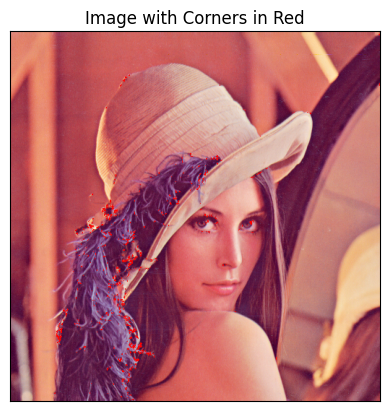

In [15]:
# use 'find_corners' to locate corners in 'lena.png'
img_with_corners = find_corners(os.path.join(data_path, 'lena.png'))
plt.imshow(img_with_corners);
plt.title('Image with Corners in Red'), plt.xticks([]); plt.yticks([]);

In [16]:
#@title { vertical-output: true}

print(f"Play with the parameters and observe their effect")

interact(
    find_corners,
    file_path=fixed(os.path.join(data_path, 'lena.png')),
    blockSize=IntSlider(value=2, min=2, max=10, step=1),
    ksize=IntSlider(value=3, min=3, max=15, step=2),
    alpha=FloatSlider(value=0.04, min=0.01, max=0.1, step=0.01)
);

Play with the parameters and observe their effect


interactive(children=(IntSlider(value=2, description='blockSize', max=10, min=2), IntSlider(value=3, descripti…

#Image Compression

In [17]:
def compress(col_img, k=10):
  # convert to grayscale
  gray = cv.cvtColor(col_img, cv.COLOR_BGR2GRAY)
  m, n = gray.shape

  # Singular Value Decomposition
  U, S, Vh = svd(gray)
  S_diag = np.diag(S)

  # compression with first 'k' singular values
  comp_img = np.dot(np.dot(U[:, :k], S_diag[:k, :k]), Vh[:k, :])

  return comp_img

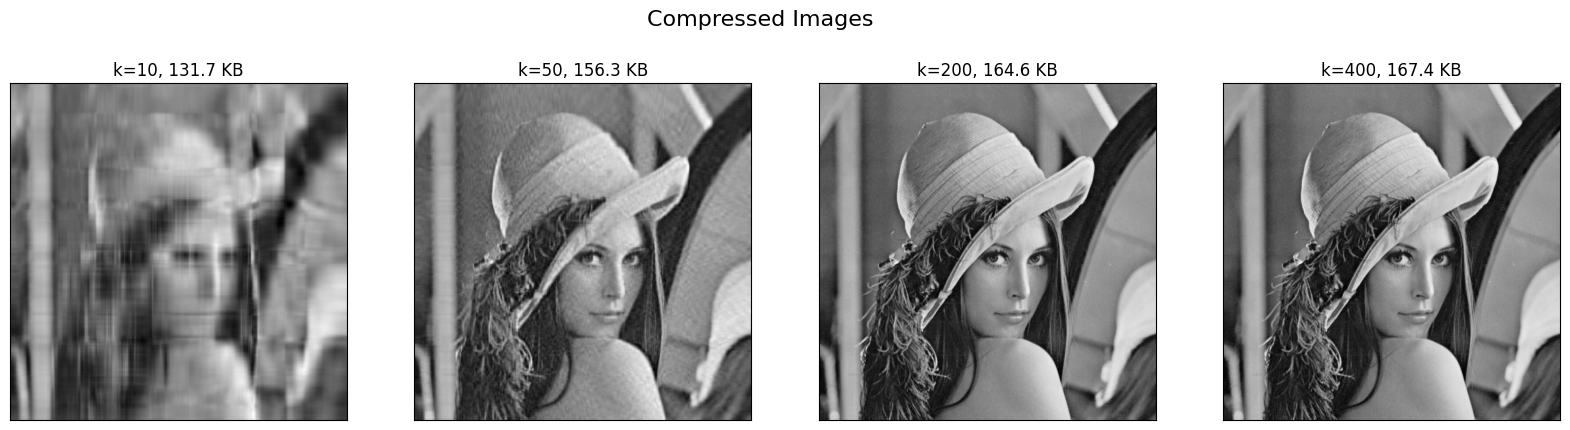

In [18]:
# Compress the image with 'k' as 10, 50, 200, and 400 separately.
# Display each image along with its compressed size (use helper function).

id = 1
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
f.suptitle("Compressed Images", fontsize=16)

img_lena = cv.imread(os.path.join(data_path, 'lena.png'))

for k in [10, 50, 200, 400]:
  comp_img = compress(img_lena, k=k)

  saved_at = os.path.join(data_path, f"lena_k_{k}.png")
  if not os.path.exists(saved_at):
    cv.imwrite(saved_at, comp_img)

  plt.subplot(int("14"+f"{id}")), plt.imshow(comp_img, cmap='gray')
  plt.title(f"k={k}, {size_in_kb(saved_at)}"), plt.xticks([]), plt.yticks([])
  id = id + 1

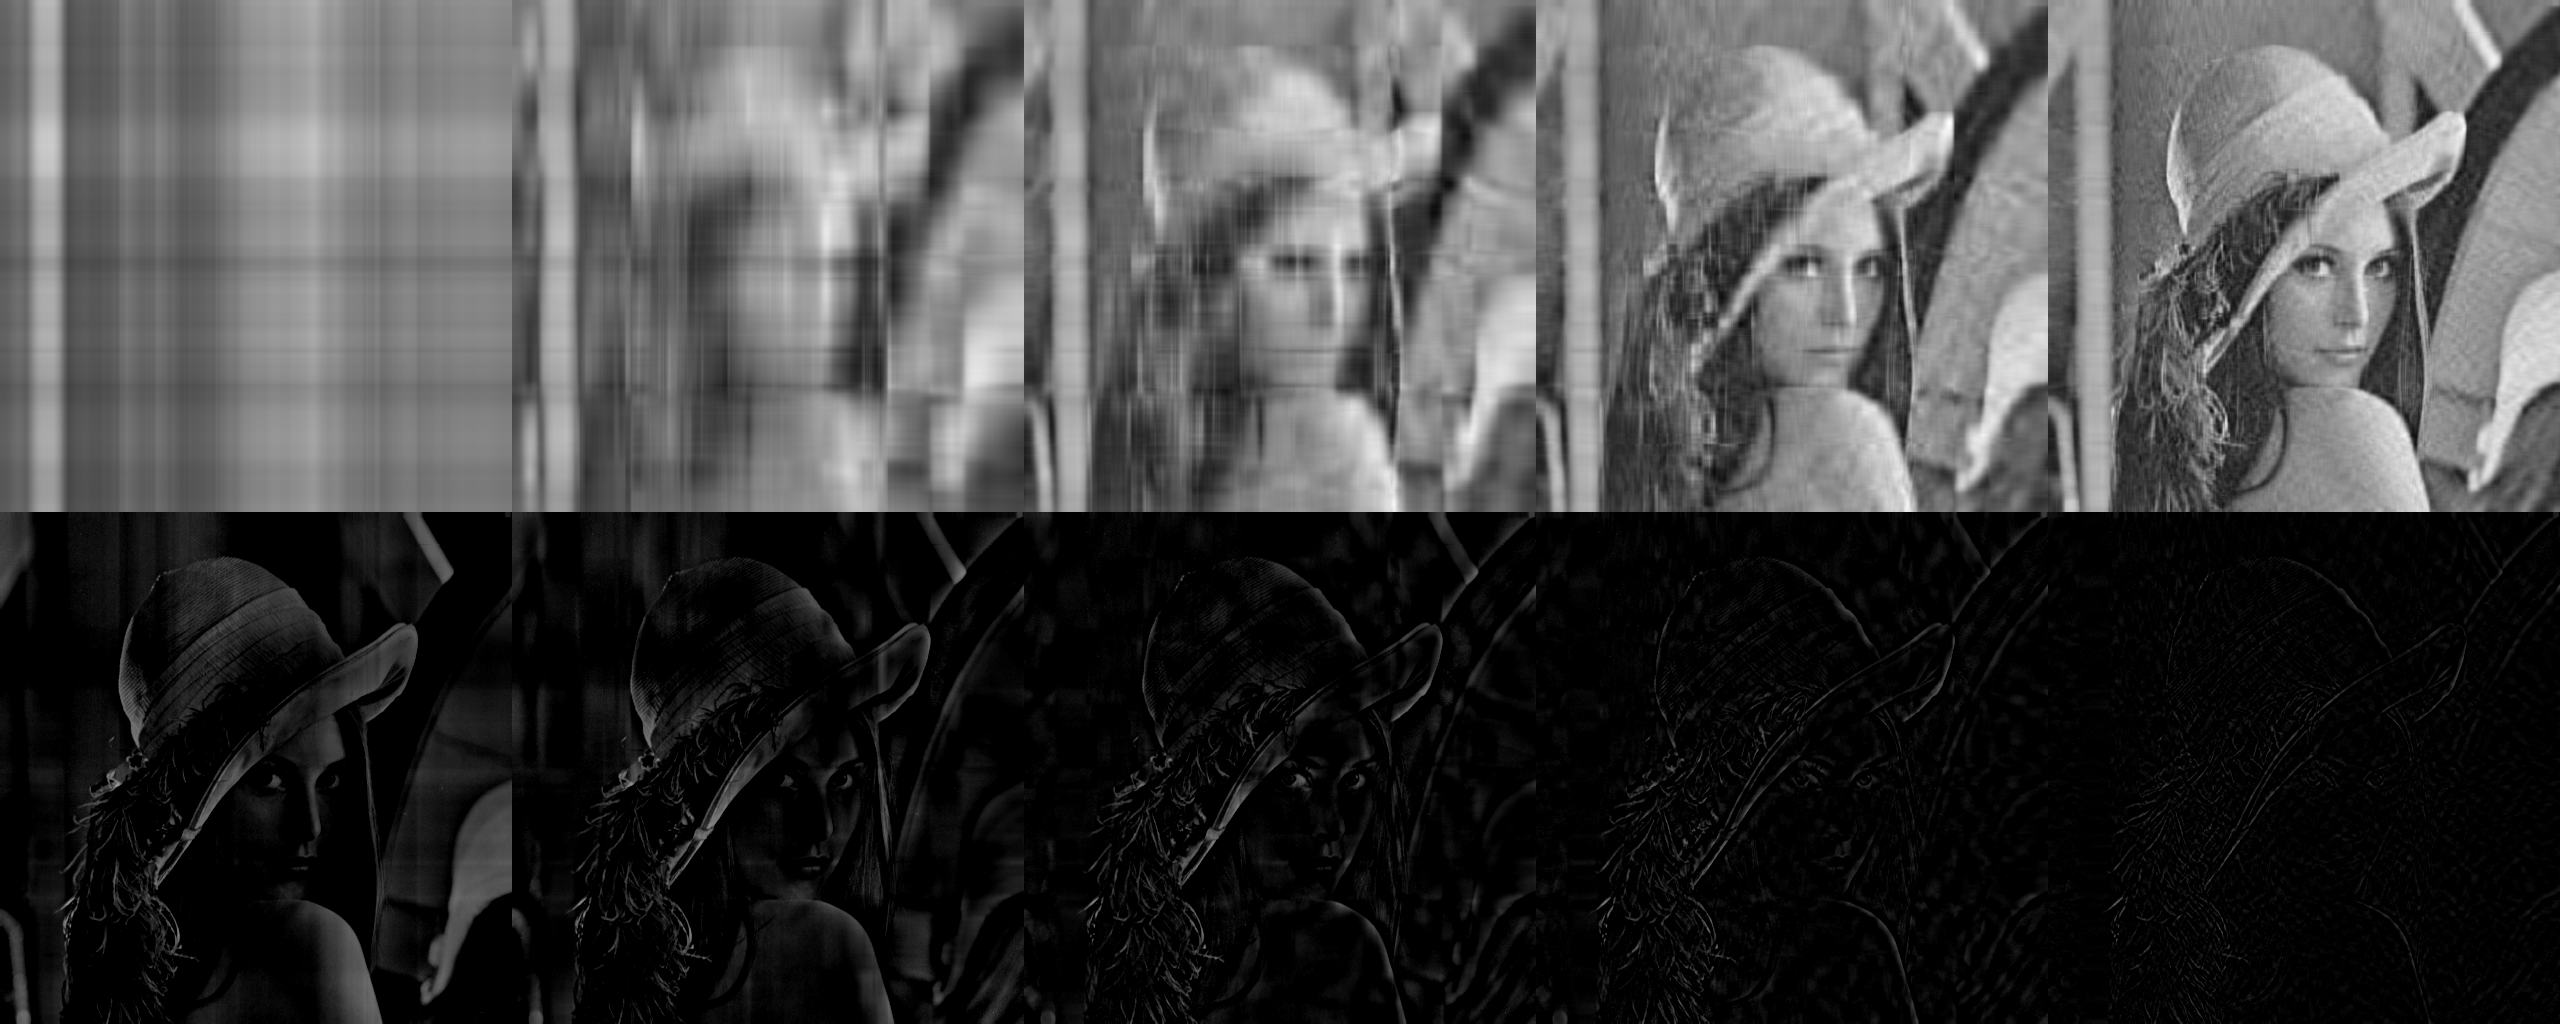

In [19]:
# Compress the image with 'k' as 1, 5, 10, 20, and 40 separately.
# Find the difference between each compressed image and original image.
# Display each compressed image alongside corresponding difference image.
# Give your observations.

img_list_1 = [compress(img_lena, 1)]
img_lena_gray = cv.cvtColor(img_lena, cv.COLOR_BGR2GRAY)
diff_list_1 = [img_lena_gray - img_list_1[0]]

for k in [5, 10, 20, 40]:
  comp_img = compress(img_lena, k)
  img_list_1.append(comp_img)
  diff_list_1.append(img_lena_gray - comp_img)

img_combined = np.hstack(tuple(img_list_1))
diff_combined = np.hstack(tuple(diff_list_1))
row_1 = np.vstack((img_combined, diff_combined))
cv2_imshow(row_1)

In [20]:
del img_combined, diff_combined

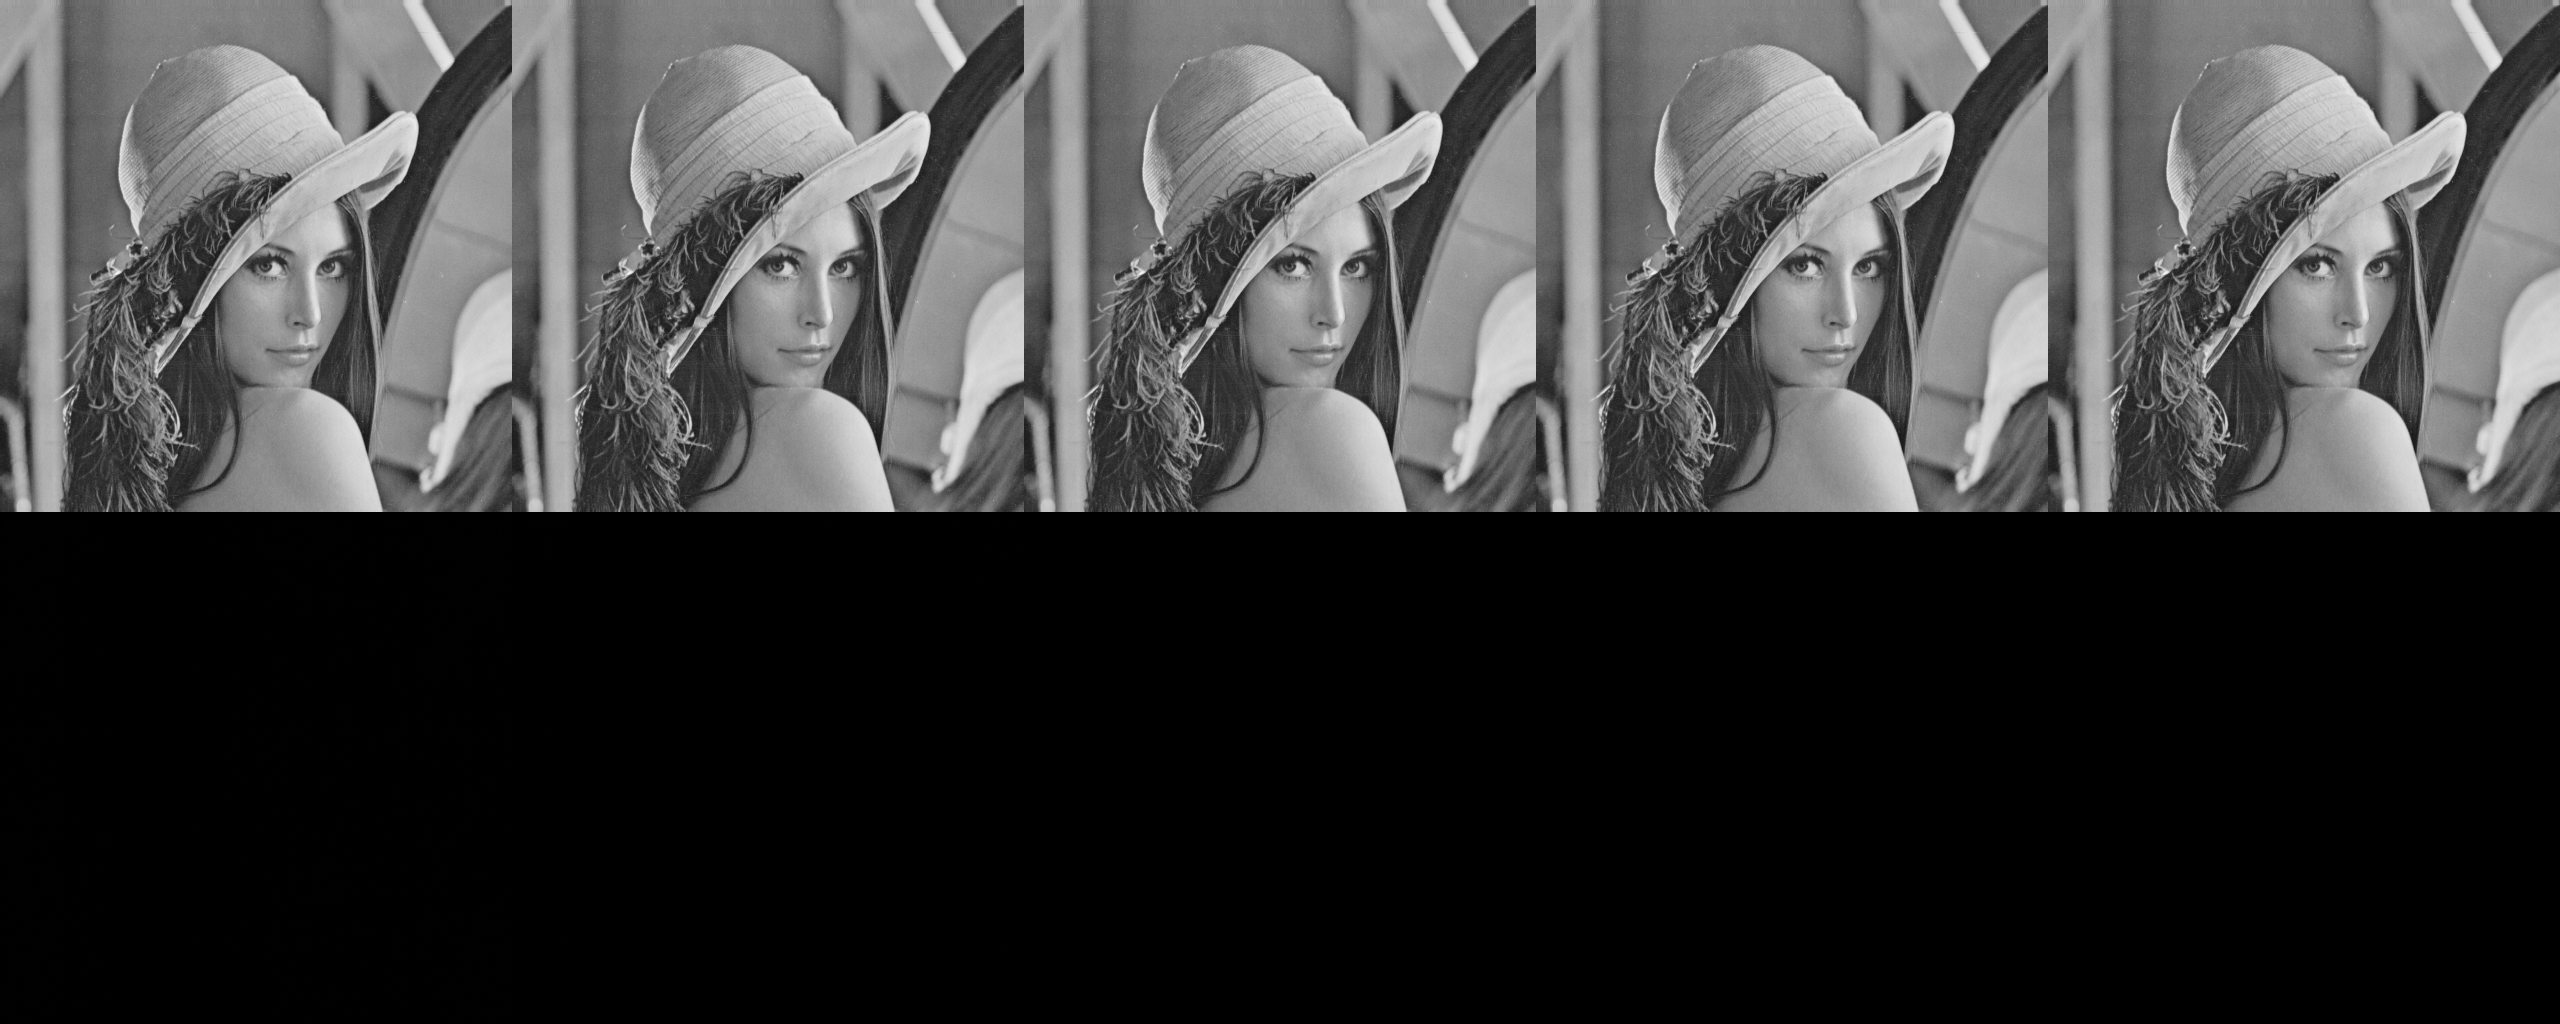

In [21]:
# Compress the image with 'k' as 300, 350, 400, 450, and 500 separately.
# Find the difference between each compressed image and original image.
# Display each compressed image alongside corresponding difference image.
# Give your observations.

img_list_2 = [compress(img_lena, 300)]
img_lena_gray = cv.cvtColor(img_lena, cv.COLOR_BGR2GRAY)
diff_list_2 = [img_lena_gray - img_list_2[0]]

for k in [350, 400, 450, 500]:
  comp_img = compress(img_lena, k)
  img_list_2.append(comp_img)
  diff_list_2.append(img_lena_gray - comp_img)

img_combined = np.hstack(tuple(img_list_2))
diff_combined = np.hstack(tuple(diff_list_2))
row_2 = np.vstack((img_combined, diff_combined))
cv2_imshow(row_2)

In [22]:
np.mean(diff_combined[0])*1e6

30.425163323211102

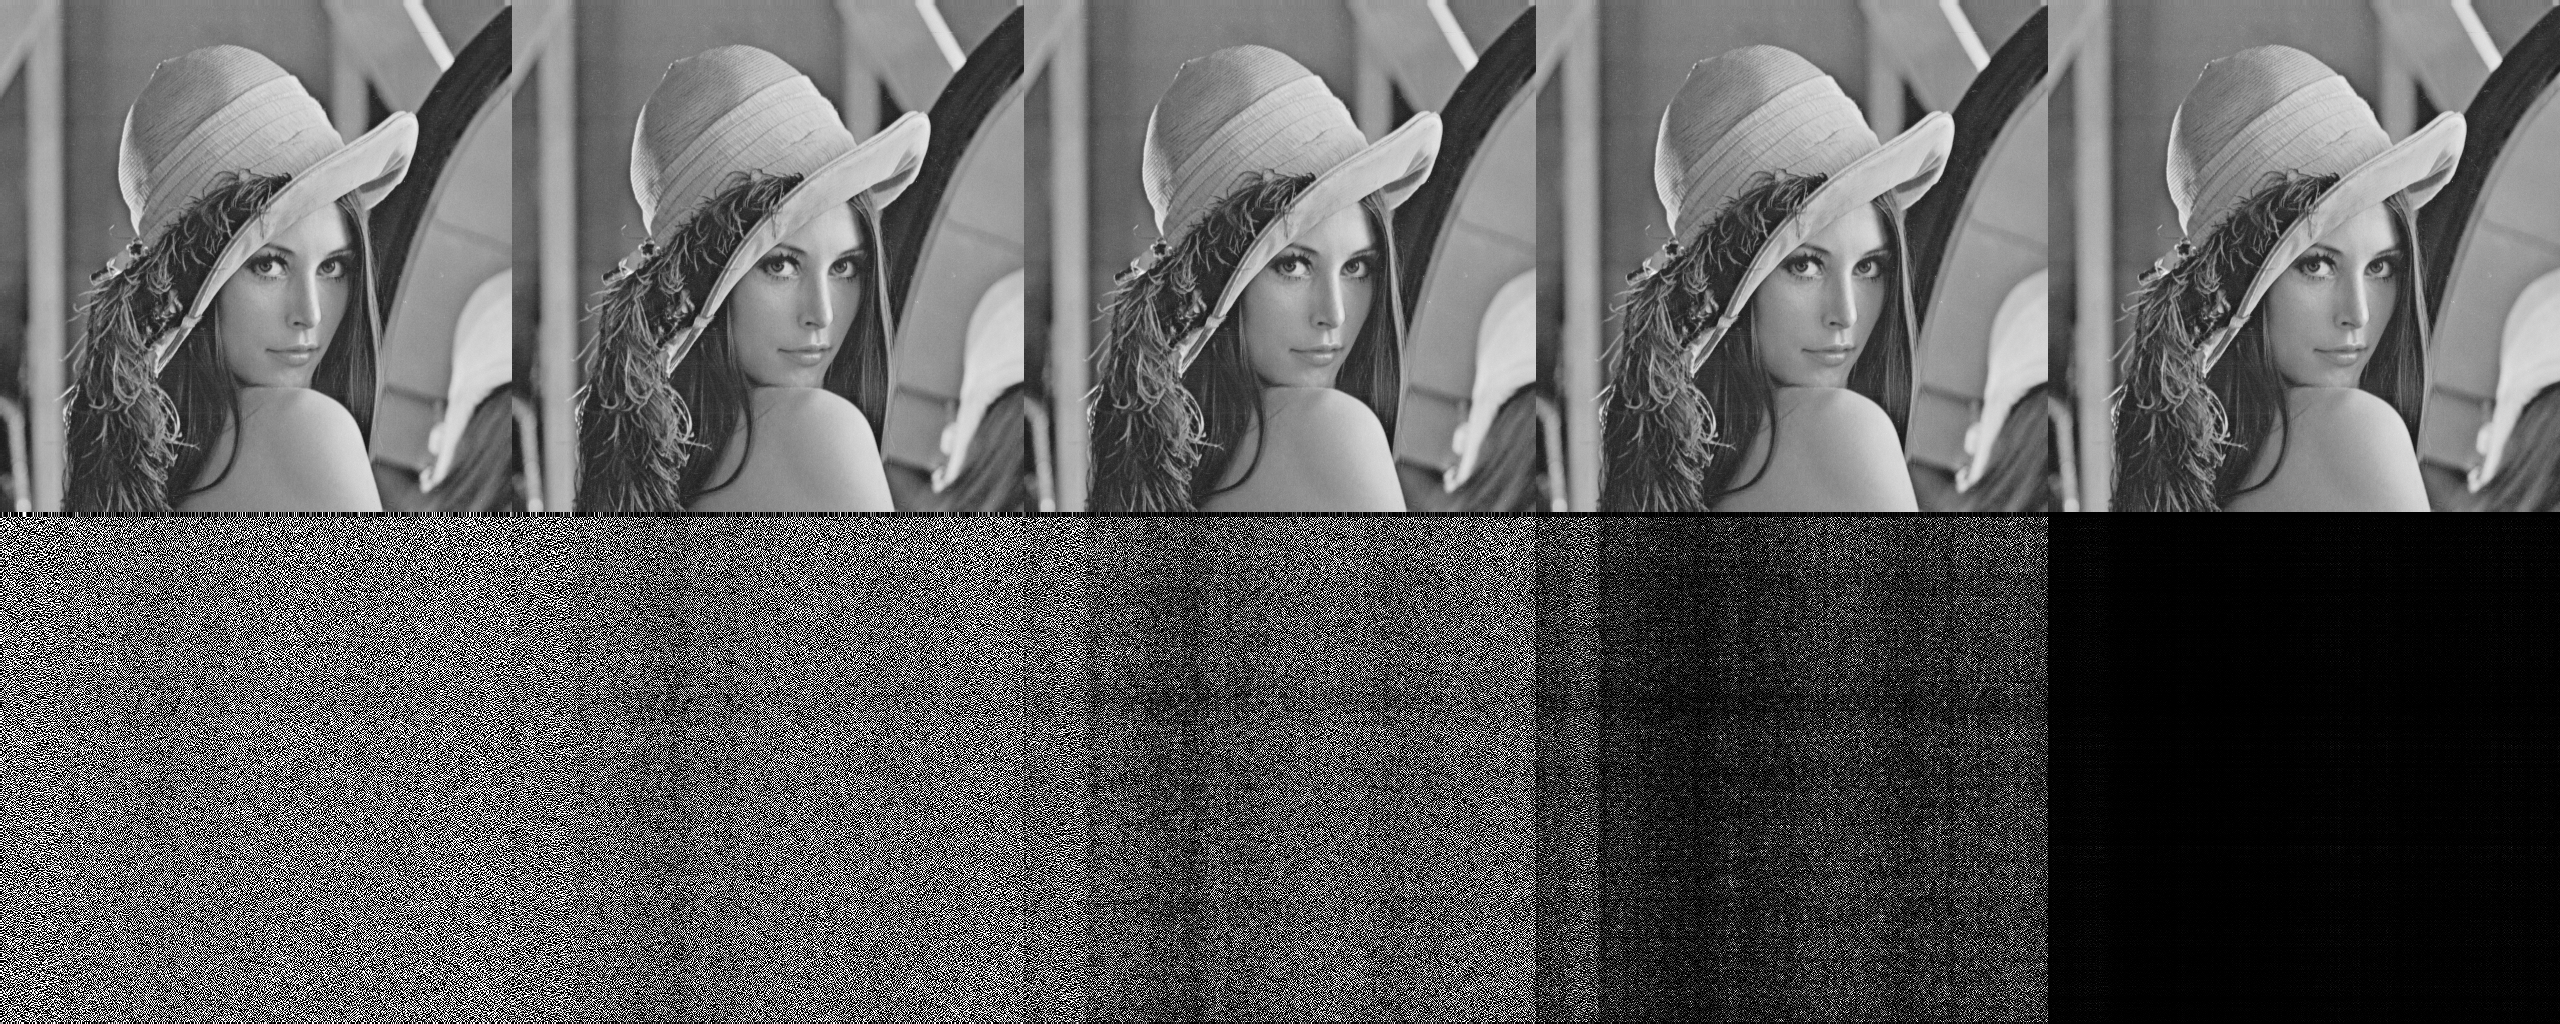

In [23]:
img_combined = np.hstack(tuple(img_list_2))
diff_combined = np.hstack(tuple(diff_list_2))
row_2 = np.vstack((img_combined, diff_combined*1e3))
cv2_imshow(row_2)

# Image Filtering

In [24]:
def Fourier_Transform(img):
  '''
  Calculates Fast Fourier Transform of input image
  '''
  # calculate FFT
  ft                  = np.fft.fft2(img)
  fshift              = np.fft.fftshift(ft)  # complex
  magnitude_spectrum  = 20 * np.log(np.abs(fshift) + 1e-6)

  # plot input image and corresponding frequency image
  f = plt.figure()
  f.set_figwidth(10)
  f.set_figheight(5)

  plt.subplot(121), plt.imshow(img, cmap = 'gray')
  plt.title('Input Image'), plt.xticks([]); plt.yticks([]);

  plt.subplot(122), plt.imshow(magnitude_spectrum, cmap = 'gray')
  plt.title('Frequency Domain'), plt.xticks([]); plt.yticks([]);

  return fshift

def Inverse_Fourier_Transform(f_shift):
  '''
  Calculates Inverse Fast Fourier Transform of input frequency image
  '''
  # calculate IFFT
  f_ishift            = np.fft.ifftshift(f_shift)
  magnitude_spectrum  = 20 * np.log(np.abs(f_shift) + 1e-6)
  img_back            = np.fft.ifft2(f_ishift)

  # plot input frequency image and inverse image
  f = plt.figure()
  f.set_figwidth(10)
  f.set_figheight(5)

  plt.subplot(121), plt.imshow(magnitude_spectrum, cmap = 'gray')
  plt.title('Frequency Domain'), plt.xticks([]); plt.yticks([]);

  plt.subplot(122), plt.imshow(np.real(img_back), cmap = 'gray')
  plt.title('Image'), plt.xticks([]); plt.yticks([]);

  return img_back

Find FFT of each of the images fourier_x.png in /mydata

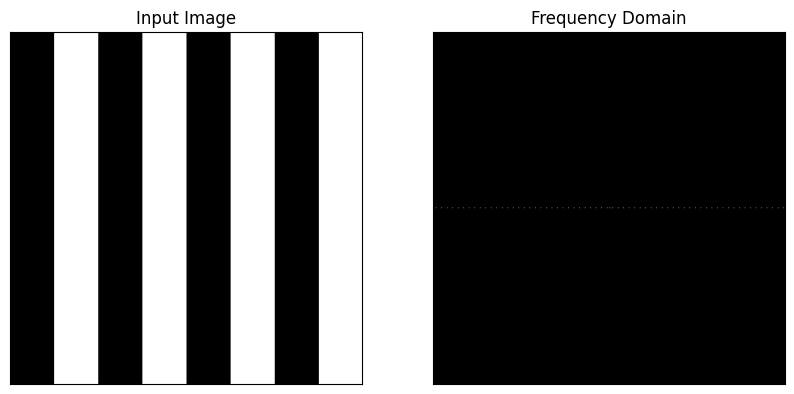

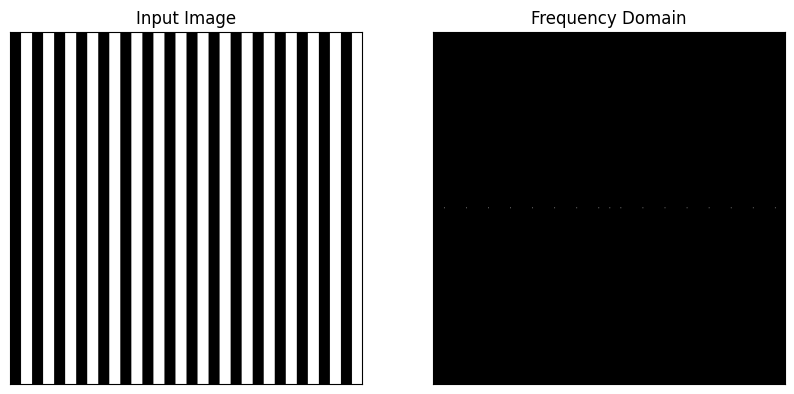

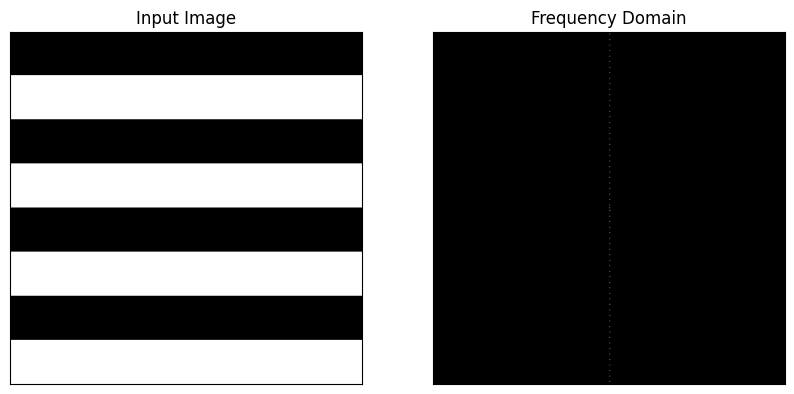

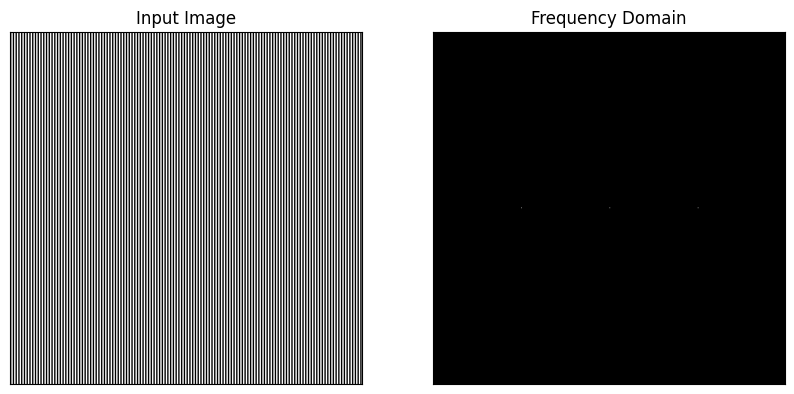

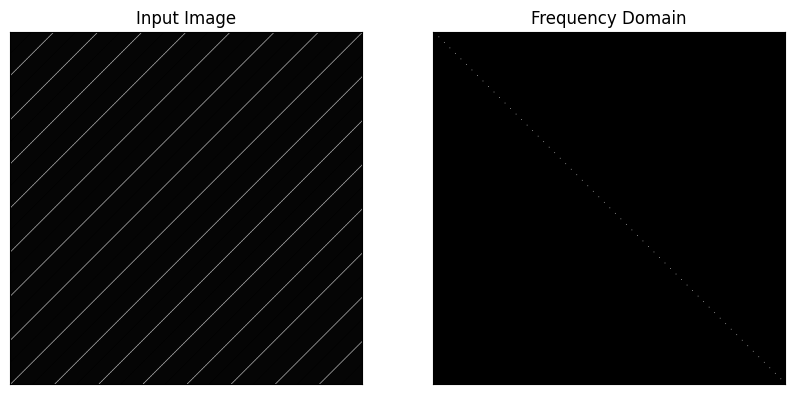

In [25]:
for i in [1, 2, 3, 4, 5]:
  img_path = os.path.join(data_path, 'fourier_'+str(i)+'.png')
  _ = Fourier_Transform(cv.imread(img_path, cv.IMREAD_GRAYSCALE))

Find FFT of lena.png

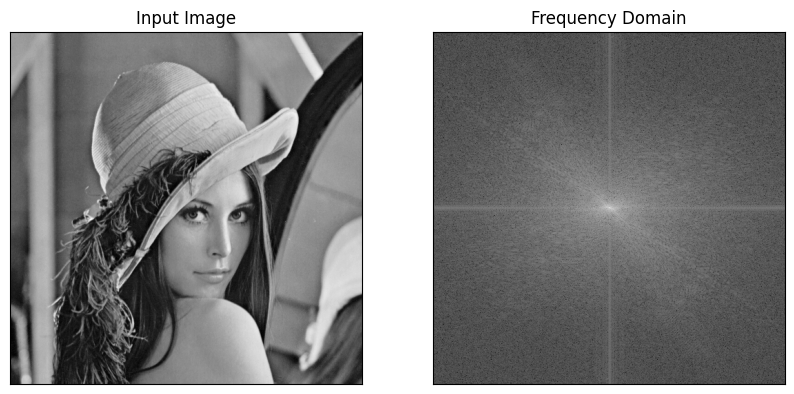

In [122]:
lena_ms_orig = Fourier_Transform(cv.imread(os.path.join(data_path, 'lena.png'), cv.IMREAD_GRAYSCALE))

In [27]:
summary(np.abs(lena_ms_orig))

min: 7.58
max: 34715021.0
mean: 4817.22
median: 1723.26


Implement a High Pass Filter on lena.png such that it leaves only the edges information on the filtered image.

In [87]:
# high pass filter
lena_ms = np.copy(lena_ms_orig)
lena_ms[np.abs(lena_ms) > 1e5] = 0  # works good with img_lena_gray
# lena_ms[np.abs(lena_ms) > 5e4] = 0

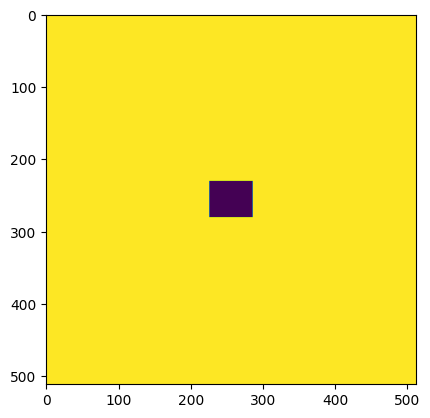

In [134]:
mask = freq_mask(img_lena_gray.shape, 30, 25)
plt.imshow(mask);

In [135]:
lena_ms = np.multiply(mask, lena_ms_orig)

In [136]:
summary(np.abs(lena_ms))

min: 0.0
max: 128015.51
mean: 3442.69
median: 1678.44


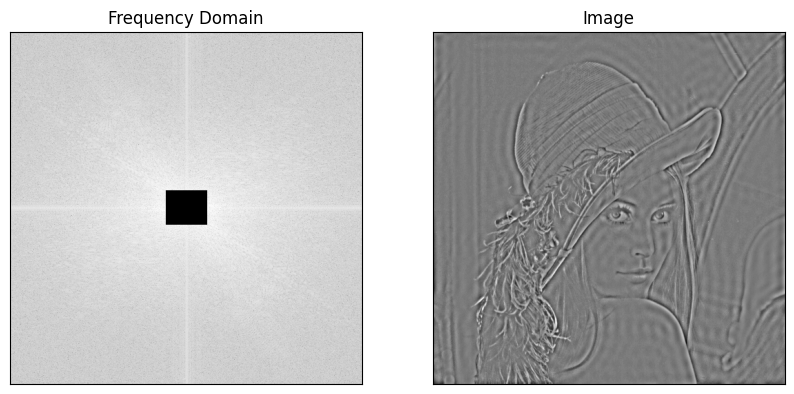

In [137]:
lena_ift = Inverse_Fourier_Transform(lena_ms)

# FinTech

Social media networking company NetworkIn wants to use latest technology for its new software version. It has hired a bunch of interns to work on parts of the project. You are working for their FinTech division. You are tasked with creating a model for presenting to the CFO, who will decide whether to move forward with this technology or work on alternate options.

NetworkIn works two ways: first it gets revenue from its subscriber base for using its platform for connecting with other people, second it charges fees to potential employers to circulate their job advertisements through its subscriber network.

A typical network is represented by a set of nodes connected by edges. Node zero being the central server from where the updates pass on to user devices, denoted by remaining nodes. To boost security, NetworkIn wants to use Blockchain to pass the updates. You need to figure the best way to do this. Inputs from other teams will also affect your decision.

## Blockchain Network

Start by creating a model for the software update scheme. Operating costs increase with increasing distance between central server and target server. One way is to broadcast the updates all at once. Use the model to conclude whether there is any better way that will cost less (so that updates travel lesser overall distance from the central server).

In [31]:
# read the network graph
G = read_network_from_file(os.path.join(data_path, 'network_1.txt'))
N_Nodes = len(G)
print(G)

Graph with 20 nodes and 85 edges


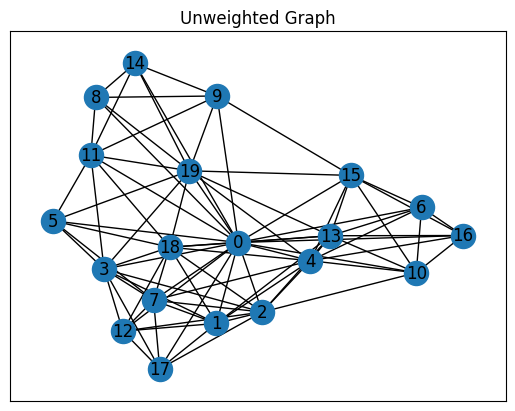

In [32]:
# Display graph
if N_Nodes < 25:
  nx.draw_networkx(G)
  plt.title('Unweighted Graph')
  plt.show()

You can index into the graph with following ways:

G.edges[i, j]: selects edge between nodes i, j

G.edges[(i, j)]: selects edge between nodes i, j

G.edges[i, j]['weight']: gives weight of edge between nodes i, j

In [33]:
# find broadcast distance
bc_dist = 0
for j in range(1, N_Nodes):
  bc_dist += G.edges[0, j]['weight']
bc_dist = np.around(bc_dist)
print(f"Broadcast distance {np.around(bc_dist, 2)}")

Broadcast distance 12.0


In [34]:
broadcast_edges = [(0, i) for i in range(N_Nodes - 1)]

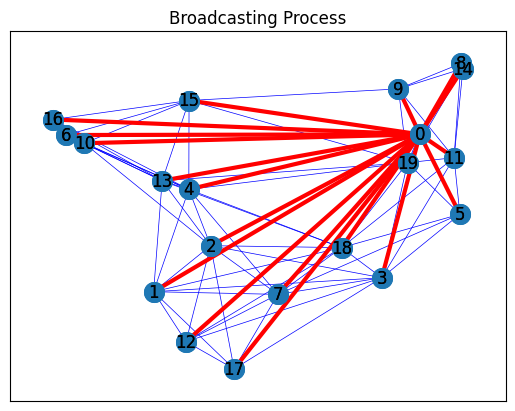

In [35]:
if len(G) < 25:
  pos = nx.get_node_attributes(G, "pos")
  nx.draw_networkx(
      G,
      pos,
      with_labels=True,
      edge_color='blue',
      node_size=200,
      width=0.5
  )
  nx.draw_networkx(
      G,
      pos,
      with_labels=True,
      edgelist=broadcast_edges,
      edge_color='red',
      node_size=200,
      width=3
  )
  plt.title('Broadcasting Process')
  plt.show()

In [36]:
def optimise_dist(G):

  H = G.copy()

  # Calculating the distances between the nodes as edge's weight.
  # Also need to make G a complete graph (with 0.5*n*(n-1) many edges)
  # for using Christofides algorithm (implemented below)

  pos = nx.get_node_attributes(G, "pos")
  for i in range(len(pos)):
      for j in range(i + 1, len(pos)):
          dist = np.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])*np.random.randint(1, 3)
          G.add_edge(i, j, weight=dist)

  cycle     = nx_app.christofides(G, weight="weight") # G must be complete graph
  edge_list = list(nx.utils.pairwise(cycle))

  # drawing network with optimum route
  if len(G) < 25:
    nx.draw_networkx_edges(H, pos, edge_color="blue", width=0.5)

    # Draw the route
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        edgelist=edge_list,
        edge_color='red',
        node_size=200,
        width=3,
        label='Shortest Path'
    )
    plt.title('Optimisation Result')
    plt.legend()
    plt.show()

  # calculate optimum route
  opt_dist = 0
  for pair in edge_list:
    opt_dist += G.edges[pair]['weight']
  opt_dist = np.around(opt_dist)

  print(f"Optimum distance {opt_dist}")
  print(f"The optimum route through the network is:\n{cycle}")

  return opt_dist

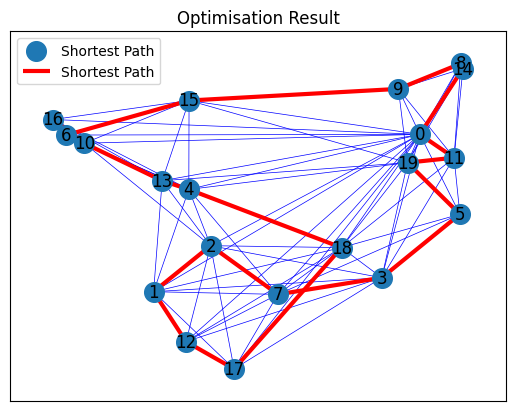

Optimum distance 4.0
The optimum route through the network is:
[0, 14, 8, 9, 15, 6, 16, 10, 13, 4, 18, 17, 12, 1, 2, 7, 3, 5, 19, 11, 0]


In [37]:
# Reduce broadcast distance by placing central server at
# geometric center
# pos = nx.get_node_attributes(G, "pos")
# pos[0] = [0.5, 0.5]
opt_dist = optimise_dist(G)
# del G

## Ads Strategy

Marketing team is trying to assess which advertisement strategy they should choose for increasing the revenue of the product. They have shared with you three tentative reward schemes. Each subscriber gets a 'basic' account for free upon subscribing to NetworkIn. They can upgrade to 'gold' for 500 and to 'premium' for 2000 per month basis. Each scheme gives different reward for these account types.

Use Nash Equilibrium (function is already provided for you) to predict best advertisement strategy.

In [38]:
def Nash_Equilibrium(A):
  game        = nash.Game(A)
  equilibria  = game.support_enumeration()
  print(game)
  print("\nNash equilibria:")

  for eq in equilibria:
    row_player, col_player  = eq
    # print(game[row_player, col_player])
    row_player_rewards      = np.dot(np.dot(row_player, A), col_player)
    print(row_player, col_player)
    print(f"\nRewards:\n{np.around(row_player_rewards, 2)}")

  return np.array(row_player), np.array(col_player)

In [39]:
# # random walk example
# A = np.array([[1, -1],
#               [-1, 1]])
# Nash_Equilibrium(A)

# # first incentive scheme reward matrix
# A = np.array([[5, 0, 4],
#               [3, 5, 2],
#               [1, 7, 8]])
# p_vec, _ = Nash_Equilibrium(A)

# second incentive scheme reward matrix
A = np.array([[0, 7, 9],
              [2, 5, 7],
              [5, 3, 5]])
p_vec, _ = Nash_Equilibrium(A)

# # fixed total incentives scheme reward matrix
# A = np.array([[2, 5, 7],
#               [3, 3, 2],
#               [5, 2, 1]])
# p_vec, _ = Nash_Equilibrium(A)

Zero sum game with payoff matrices:

Row player:
[[0 7 9]
 [2 5 7]
 [5 3 5]]

Column player:
[[ 0 -7 -9]
 [-2 -5 -7]
 [-5 -3 -5]]

Nash equilibria:
[0.22222222 0.         0.77777778] [0.44444444 0.55555556 0.        ]

Rewards:
3.89


## Demand Forecast

Sales team has shared advertisement demand prediction, using their latest Machine Learning model (one of the variables used was stock price of the company), over the next 6 months (their team has worked very hard on this).

Before moving forward, you need to figure out the best way to analyse this forecast. Your reasonings will be part of the report presented to the CFO.

min: 1.0
max: 90.0
mean: 47.72
median: 45.5


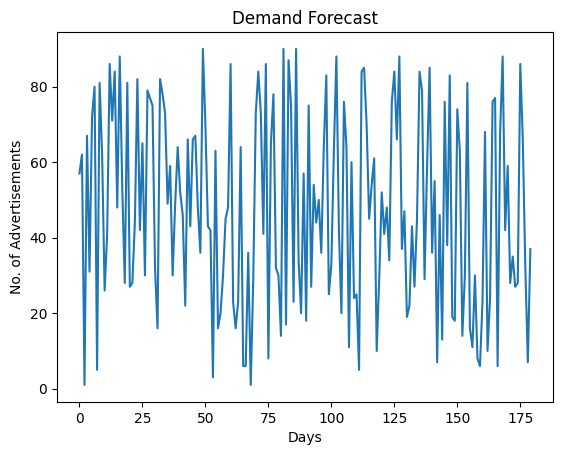

In [40]:
# read demand forecast for 6 months and plot the results
demand = np.loadtxt(os.path.join(data_path, 'demand_2.txt'))
plt.plot(demand); plt.xlabel('Days'); plt.ylabel('No. of Advertisements');
plt.title('Demand Forecast')
summary(demand)

In [41]:
def fit(x, a, b, c, d):
  '''
  Implement function for fitting over data
  '''
  return a*(np.power(x, 3)) + b*np.power(x, 2) + c*x + d

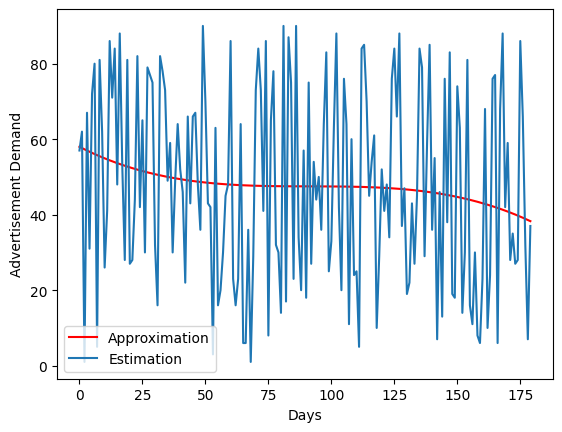

In [42]:
# plot demand for first 'n' months
x_range     = np.arange(0, 30*6, 1)

n_months    = 6

xdata       = x_range[:30 * n_months]
ydata       = demand[:30 * n_months]

# curve fitting
popt, pcov  = curve_fit(fit, xdata, ydata)
yfit        = fit(xdata[:30 * n_months], *popt)

# display curve over fitted data
plt.plot(yfit, 'r-', label='Approximation');
plt.plot(ydata, label='Estimation');
plt.xlabel('Days'); plt.ylabel('Advertisement Demand');
plt.legend();

**Note:**

As additional tasks:

1) see whether you can find outliers or anomalies in the data.

2) better ways of dealing with uncertainty in the data.

## Financial Model

In [43]:
def financial_model(fixed_cost, dist_rate, opt_dist, p_vector, n_nodes, y_forecast):
  # operational costs
  fees_per_add  = 100
  opt_cost      = fixed_cost + opt_dist * dist_rate

  # define 3 subscription plans
  subscriptions = {'basic': 0,
                  'gold': 500,
                  'premium': 2000}

  # calculate subscription distribution from simulated Ads Strategy
  subs_demand   = [np.random.choice(
                  ['basic', 'gold', 'premium'],
                  replace=True,
                  p=p_vector
              ) for _ in range(n_nodes-1)]

  # calculate platform revenue
  platform_revenue  = np.sum([subscriptions[sub] for sub in subs_demand])

  # calculate ads revenue
  ads_revenue       = np.sum(y_forecast)*fees_per_add

  # calculate net profit
  net_profit        = (platform_revenue + ads_revenue) - opt_cost

  return np.around(platform_revenue, 2),\
          np.around(ads_revenue, 2),\
          np.around(opt_cost, 2),\
          np.around(net_profit, 2)

In [44]:
def fixed_cost():
  # staff
  staff_pay = {
      'CEO': 100000,
      'CFO': 100000,
      'CTO': 100000,
      'Algo Eng I': 70000,
      'Algo Eng II': 85000,
      'SDE I': 50000,
      'SDE II': 65000,
      'SDE III': 75000,
      'IT Eng I': 45000,
      'IT Eng II': 65000,
      'CS Team Lead': 95000,
      'FinTech Eng': 80000,
      'Fin Exp': 95000,
      'Crypto Exp': 95000
  }

  # technology cost
  tech_cost = {
      'hardware': 15000,
      'software': 75000
  }

  # miscellaneous cost
  misc_cost = 145000

  return np.sum(list(staff_pay.values()))+\
          np.sum(list(tech_cost.values()))+\
          misc_cost

In [45]:
fixed_cost()

1355000

In [46]:
p_rev, a_rev,\
ops_cost,\
net_profit = financial_model(
    fixed_cost=fixed_cost(),
    dist_rate=10,
    opt_dist=opt_dist,
    p_vector=p_vec,
    n_nodes=N_Nodes,
    y_forecast=yfit[:30 * n_months]
)

print(p_rev, a_rev, ops_cost, net_profit)

32000 858900.0 1355040.0 -464140.0


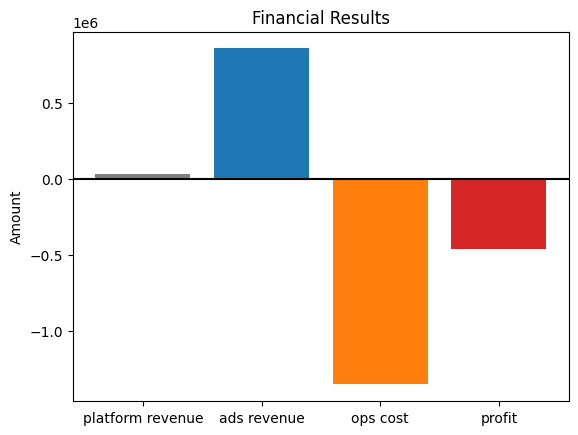

In [47]:
# display financial analytics

fig, ax = plt.subplots()

labels = ['platform revenue', 'ads revenue', 'ops cost', 'profit']
counts = [p_rev, a_rev, ops_cost*(-1), net_profit]

if net_profit > 0:
  bar_colors = ['tab:gray', 'tab:blue', 'tab:orange', 'tab:green']
else:
  bar_colors = ['tab:gray', 'tab:blue', 'tab:orange', 'tab:red']

ax.bar(labels, counts, color=bar_colors)
plt.axhline(0, color='black')
ax.set_ylabel('Amount')
ax.set_title('Financial Results')

plt.show()